# Demand prediction for theme parks (specific case of USS)

In [97]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import simpy
from datetime import datetime, timedelta
import os
os.chdir("C:/Users/parma/data-science-guest-experience/data-science-guest-experience/Scripts/Subgroup_B")

## Loading datasets
### Load survey data
Loads and preprocesses Universal Studios Singapore survey data, extracting useful features for demand modeling — especially when IoT data is unavailable.

Purpose:
- Prepares a cleaned dataset from raw survey responses by:
- Converting subjective text-based responses into numerical features
- Mapping ride wait times into numerical estimates
- Normalizing guest satisfaction scores
- Inferring seasonal context from survey answers
- Generating additional data rows for longer-than-expected wait experiences
- Filtering to focus only on major attractions

Returns a cleaned pd.DataFrame with relevant columns like:
- Attraction:	Ride name
- Wait_Time:	Numeric estimated wait time
- Guest_Satisfaction_Score:	Normalized score (0–1)
- Event:	'None' or 'Special Event'
-  Season:	One of four seasonal groupings
- Other optional demographic columns like: 'Did you purchase the Express Pass?', 'Who did you visit USS with?', etc.	


In [98]:
def load_survey_data(file_path="../../data/survey.csv"):
    import os
    import pandas as pd
    import numpy as np

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found. Please provide the survey dataset.")

    df = pd.read_csv(file_path)

    # Step 1: Rename columns if they exist
    rename_map = {
        "Which age group do you belong to?": "Age_Group",
        "What is your employment status?": "Employment_Status",
        "Which part of the year did you visit USS?": "Visit_Season",
        "Which ride or attraction was your favourite?": "Favorite_Attraction",
        "Why this attraction in particular? ": "Attraction_Reason",
        "Did you experience any rides with longer-than-expected wait times? If yes, which ride(s)?": "Long_Wait_Attractions",
        "How long did you wait in line for rides on average during your visit?": "Avg_Wait_Time",
        "On a scale of 1-5, how would you rate your overall experience at USS?": "Satisfaction_Score"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    # Step 2: Map attractions to standardize names
    attraction_map = {
        "CYLON": "Battlestar Galactica: CYLON",
        "HUMAN": "Battlestar Galactica: HUMAN",
        "Transformers": "Transformers: The Ride",
        "Revenge of the Mummy": "Revenge of the Mummy",
        "Sesame Street Spaghetti Space Chase": "Sesame Street Spaghetti Space Chase",
        "Puss in Boots": "Puss In Boots' Giant Journey",
        "Canopy Flyer": "Canopy Flyer",
        "Treasure Hunters": "Treasure Hunters"
    }

    # Map attractions in 'Favorite_Attraction'
    if 'Favorite_Attraction' in df.columns:
        df['Favorite_Attraction'] = df['Favorite_Attraction'].apply(lambda x: attraction_map.get(x, x))

    # Map attractions in 'Long_Wait_Attractions' (if available)
    if 'Long_Wait_Attractions' in df.columns:
        df['Long_Wait_Attractions'] = df['Long_Wait_Attractions'].apply(lambda x: [attraction_map.get(a, a) for a in x.split(", ")] if isinstance(x, str) else x)

    df.reset_index(drop=True, inplace=True)

    # Step 3: Map wait time categories
    wait_time_map = {
        "Less than 15 mins": 10,
        "15-30 mins": 22.5,
        "30-45 mins": 37.5,
        "45 mins - 1 hr": 52.5,
        "More than 1 hr": 75
    }
    if "Avg_Wait_Time" in df.columns:
        df["Avg_Wait_Time"] = df["Avg_Wait_Time"].map(wait_time_map).fillna(37.5)
    else:
        df["Avg_Wait_Time"] = 37.5

    # Step 4: Normalize satisfaction score
    df["Satisfaction_Score"] = pd.to_numeric(df.get("Satisfaction_Score", 3), errors="coerce")
    df["Satisfaction_Score"] = (
        (df["Satisfaction_Score"] - df["Satisfaction_Score"].min()) /
        (df["Satisfaction_Score"].max() - df["Satisfaction_Score"].min())
    )

    # Step 5: Convert fuzzy seasons into quarterly buckets
    def infer_season(val):
        if pd.isna(val) or val.strip().lower() == "can't recall / not sure":
            return np.random.choice(["Jan-Mar", "Apr-Jun", "Jul-Sep", "Oct-Dec"], p=[0.1, 0.1, 0.6, 0.2])
        val = val.lower()
        if any(month in val for month in ["jan", "feb", "mar"]):
            return "Jan-Mar"
        elif any(month in val for month in ["apr", "may", "jun"]):
            return "Apr-Jun"
        elif any(month in val for month in ["jul", "aug", "sep"]):
            return "Jul-Sep"
        elif any(month in val for month in ["oct", "nov", "dec"]):
            return "Oct-Dec"
        return "Jul-Sep"

    df["Visit_Quarter"] = df.get("Visit_Season", "Jul-Sep").apply(infer_season)

    # Step 6: Assign synthetic event
    np.random.seed(42)
    df["Event"] = np.random.choice(["None", "Special Event"], size=len(df), p=[0.8, 0.2])

    # Step 7: Explode long wait attractions
    long_wait_df = pd.DataFrame()
    if "Long_Wait_Attractions" in df.columns:
        exploded = df["Long_Wait_Attractions"].dropna().str.split(", ", expand=True).stack().reset_index()
        exploded.columns = ['original_index', 'split_index', 'Attraction']
        exploded = exploded[exploded['Attraction'].notna()]

        wait_times = [75 + np.random.randint(0, 31) for _ in range(len(exploded))]

        def safe_get(col, default=None):
            return df[col].iloc[exploded["original_index"]].values if col in df.columns else [default] * len(exploded)

        long_wait_df = pd.DataFrame({
            "Favorite_Attraction": exploded["Attraction"],
            "Avg_Wait_Time": wait_times,
            "Satisfaction_Score": safe_get("Satisfaction_Score"),
            "Age_Group": safe_get("Age_Group"),
            "Employment_Status": safe_get("Employment_Status"),
            "Visit_Quarter": safe_get("Visit_Quarter", "Jul-Sep"),
            "Event": safe_get("Event", "None"),
            "Attraction_Reason": safe_get("Attraction_Reason")
        })

    # Step 8: Select final columns to keep
    base_columns = [
        "Favorite_Attraction", "Avg_Wait_Time", "Satisfaction_Score", "Age_Group",
        "Employment_Status", "Visit_Quarter", "Event"
    ]
    if "Attraction_Reason" in df.columns:
        base_columns.append("Attraction_Reason")

    base_df = df[base_columns].copy()
    df_combined = pd.concat([base_df, long_wait_df], ignore_index=True)

    return df_combined


In [99]:
# Load survey data and apply standardization
df_survey = load_survey_data()
print(df_survey.head())

                   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0          Battlestar Galactica: HUMAN           37.5                0.75   
1          Battlestar Galactica: HUMAN           37.5                0.75   
2               Transformers: The Ride           37.5                0.75   
3          Battlestar Galactica: CYLON           37.5                0.75   
4  Sesame Street Spaghetti Space Chase           37.5                0.50   

           Age_Group Employment_Status Visit_Quarter          Event  \
0  25 - 34 years old          Employed       Oct-Dec           None   
1  18 - 24 years old           Student       Apr-Jun  Special Event   
2  18 - 24 years old           Student       Jul-Sep           None   
3  18 - 24 years old           Student       Oct-Dec           None   
4  18 - 24 years old           Student       Jul-Sep           None   

                                   Attraction_Reason  
0                                     Very exciting!  


Generating more survey data using SDV since sample size is too small. 

In [ ]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df_survey)

from sdv.single_table import GaussianCopulaSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(df_survey)

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
combined_survey_df = pd.concat([df_survey, synthetic_data], ignore_index=True)
print(combined_survey_df.head())

c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


                   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0          Battlestar Galactica: HUMAN           37.5                0.75   
1          Battlestar Galactica: HUMAN           37.5                0.75   
2               Transformers: The Ride           37.5                0.75   
3          Battlestar Galactica: CYLON           37.5                0.75   
4  Sesame Street Spaghetti Space Chase           37.5                0.50   

           Age_Group Employment_Status Visit_Quarter          Event  \
0  25 - 34 years old          Employed       Oct-Dec           None   
1  18 - 24 years old           Student       Apr-Jun  Special Event   
2  18 - 24 years old           Student       Jul-Sep           None   
3  18 - 24 years old           Student       Oct-Dec           None   
4  18 - 24 years old           Student       Jul-Sep           None   

                                   Attraction_Reason  
0                                     Very exciting!  


### Load IOT data (optional, to answer question 5)
Loads and processes synthetic IoT data representing guest behaviors at Universal Studios Singapore, used to enrich demand prediction models.

Prepares raw IoT-style activity logs by extracting temporal, contextual, and behavioral features to support queue/demand modeling for attractions and services.

Processing Steps:
1. File Existence Check: Warns and returns None if the file is not found (graceful fallback for non-IoT experiments).
2. Timestamp Parsing: Converts 'Timestamp' to proper datetime format
3. Feature Engineering

Output: Returns a cleaned pd.DataFrame with original fields plus:
Column	Description
- Timestamp:	Guest activity timestamp
- Attraction:	Ride name
- Age_Group, Gender, etc.:	Visitor demographics
- Check_In_Time / Check_Out_Time:	Check-in and check-out times from park
- Average_Queue_Time:	Reported average wait at the ride
- Number_of_People_in_Queue:	Target variable for demand modeling
- day_of_week:	Day name (e.g., Monday)
- is_weekend:	Boolean weekend indicator
- is_popular_attraction:	Boolean for high-demand rides

In [101]:
import os
import pandas as pd

def load_iot_data(file_path="../../data/synthetic_iot_data_v2.csv"):
    """
    Loads and preprocesses synthetic IoT data for analysis or modeling.

    Args:
        file_path (str): Path to the synthetic IoT CSV file.

    Returns:
        pd.DataFrame: Cleaned and enriched IoT data.
    """
    if not os.path.exists(file_path):
        print(f"Warning: IoT data file {file_path} not found. Skipping IoT data integration.")
        return None

    # Load data
    df_iot = pd.read_csv(file_path)

    # Convert 'Date' to datetime
    df_iot['Date'] = pd.to_datetime(df_iot['Date'])

    # Extract day of the week
    df_iot['Day_of_Week'] = df_iot['Date'].dt.day_name()

    # Flag for weekend visits
    df_iot['Is_Weekend'] = df_iot['Day_of_Week'].isin(["Saturday", "Sunday"])

    # Define popular attractions
    POPULAR_ATTRACTIONS = {
        "Revenge of the Mummy",
        "Battlestar Galactica: CYLON",
        "Transformers: The Ride",
        "Battlestar Galactica: HUMAN",
        "Sesame Street Spaghetti Space Chase"
    }

    # Add flag if any visited attraction is popular
    df_iot['Is_Popular_Attraction'] = df_iot['Attraction_Times'].apply(
        lambda x: any(attraction['Attraction'] in x for attraction in eval(x))  # Use eval to convert string to list of dicts
    )

    # Function to process the Attraction_Times
    def process_attraction_times(attraction_times):
        """
        Processes the attraction times to extract check-in, queue, and check-out times.
        """
        attractions_data = []

        # Convert the string representation of the list to a list of dictionaries
        attractions = eval(attraction_times)  # Safely converts stringified list into actual list of dictionaries
        for attraction in attractions:
            attractions_data.append({
                "Attraction": attraction['Attraction'],
                "Check_In": attraction['Check_In'],
                "Queue_Time": attraction['Queue_Time'],
                "Check_Out": attraction['Check_Out']
            })
        return attractions_data

    # Apply the processing function to each row in the 'Attraction_Times' column
    df_iot['Processed_Attraction_Times'] = df_iot['Attraction_Times'].apply(process_attraction_times)

    # Now you can expand the Processed_Attraction_Times list into separate rows, if necessary
    # This will create a separate row for each attraction visited
    df_iot_expanded = df_iot.explode('Processed_Attraction_Times', ignore_index=True)

    # Extract individual columns from the expanded 'Processed_Attraction_Times' list
    df_iot_expanded['Attraction'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Attraction'])
    df_iot_expanded['Check_In'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Check_In'])
    df_iot_expanded['Queue_Time'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Queue_Time'])
    df_iot_expanded['Check_Out'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Check_Out'])

    # Drop the 'Processed_Attraction_Times' column now that we've expanded it
    df_iot_expanded.drop(columns=['Processed_Attraction_Times'], inplace=True)

    # Select relevant columns based on your IoT dataset
    relevant_columns = [
        "Visitor_ID", "Date", "Loyalty_Member", "Age", "Gender", "Theme_Zone_Visited",
        "Attraction", "Check_In", "Queue_Time", "Check_Out", "Average_Queue_Time",
        "Restaurant_Spending", "Merchandise_Spending", "Total_Spending", "Day_of_Week", "Is_Weekend", "Is_Popular_Attraction"
    ]
    
    # Filter the dataframe to include only the relevant columns
    df_iot_expanded = df_iot_expanded[relevant_columns]

    return df_iot_expanded

# Example usage
df_iot = load_iot_data()
print(df_iot.head())


                             Visitor_ID       Date Loyalty_Member  Age Gender  \
0  00899c1b-2302-4b06-a341-52e9c848d829 2024-04-12            Yes   20   Male   
1  00899c1b-2302-4b06-a341-52e9c848d829 2024-04-12            Yes   20   Male   
2  00899c1b-2302-4b06-a341-52e9c848d829 2024-04-12            Yes   20   Male   
3  180a767b-fc1e-455d-babd-62fd2abddf8a 2024-09-27             No   16   Male   
4  180a767b-fc1e-455d-babd-62fd2abddf8a 2024-09-27             No   16   Male   

                                  Theme_Zone_Visited  \
0      ['New York', 'Ancient Egypt', 'Far Far Away']   
1      ['New York', 'Ancient Egypt', 'Far Far Away']   
2      ['New York', 'Ancient Egypt', 'Far Far Away']   
3  ['Hollywood', 'New York', 'Ancient Egypt', 'Th...   
4  ['Hollywood', 'New York', 'Ancient Egypt', 'Th...   

                            Attraction  Check_In  Queue_Time  Check_Out  \
0  Sesame Street Spaghetti Space Chase     11.00       48.32      11.89   
1                 Revenge 

### Checking which features are important to predict demand for IOT data
Using random forest to find features that correlate to the number of people in queue, which are the weather conditions, guest satisfaction score, and average queue time. 

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define popular attractions
POPULAR_ATTRACTIONS = {"Revenge of the Mummy", "Battlestar Galactica: CYLON", "Transformers: The Ride", "Battlestar Galactica: HUMAN"}

# Add flag if any visited attraction is popular
df_iot['Is_Popular_Attraction'] = df_iot['Attraction'].apply(
    lambda x: any(attraction in str(x) for attraction in POPULAR_ATTRACTIONS)
)

# Convert boolean columns to integers for modeling
df_iot['Is_Weekend'] = df_iot['Day_of_Week'].isin(["Saturday", "Sunday"]).astype(int)
df_iot['Is_Popular_Attraction'] = df_iot['Is_Popular_Attraction'].astype(int)

# Encode 'Theme_Zone_Visited' using Label Encoding
le = LabelEncoder()
df_iot['Theme_Zone_Visited'] = le.fit_transform(df_iot['Theme_Zone_Visited'])

# Encode 'Loyalty_Member' as 1 for 'Yes', 0 for 'No' (since it's a categorical feature)
df_iot['Loyalty_Member'] = df_iot['Loyalty_Member'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode 'Gender' as 1 (Female), 0 (Male) for simplicity
df_iot['Gender'] = df_iot['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

# Features selection based on the available columns in df_iot
features = [
    'Age', 
    'Gender', 
    'Theme_Zone_Visited', 
    'Is_Weekend', 
    'Is_Popular_Attraction',
    'Restaurant_Spending',  # Include spending for the model
    'Merchandise_Spending',  # Merchandise spending might influence queue times
    'Check_In',  # Add Check_In as a feature (it might influence queue time)
    'Queue_Time'  # Queue time might also be a relevant feature for prediction
]

# Target variable: 'Average_Queue_Time'
X = df_iot[features]
y = df_iot['Average_Queue_Time']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# Print the feature importances
print("Feature Importance:\n")
print(feature_importance)

Feature Importance:

Queue_Time               0.406285
Check_In                 0.152403
Age                      0.123042
Theme_Zone_Visited       0.109337
Restaurant_Spending      0.091711
Merchandise_Spending     0.068158
Gender                   0.017406
Is_Weekend               0.016069
Is_Popular_Attraction    0.015589
dtype: float64


## Load weather data
Fetches or loads monthly weather data from Singapore’s government open data API and aggregates it into seasonal averages to be used as input features in demand prediction models.

Purpose:
- Automates the process of downloading or loading historical monthly weather data for 2024.
- Maps each month to a seasonal category used in survey responses (e.g., "January - March").
- Outputs a clean dataset with average weather values per season.

In [103]:
def fetch_weather_data(file_path="../../data/singapore_seasonal_weather.csv"):
    """
    Fetches or loads seasonal weather data for all months of 2024,
    calculates seasonal averages, and saves the result for reuse.

    Returns:
        pd.DataFrame: Weather data averaged by season.
    """
    import os
    import requests
    import pandas as pd

    if os.path.exists(file_path):
        print(f"✅ Loaded existing weather data from: {file_path}")
        return pd.read_csv(file_path)

    print("📡 Fetching weather data from API...")

    base_url = "https://api.data.gov.sg/v1/environment/"
    weather_types = ["rainfall", "air-temperature", "relative-humidity", "wind-speed"]
    months = [f"2024-{str(m).zfill(2)}-15" for m in range(1, 13)]
    month_names = [datetime.strptime(m, "%Y-%m-%d").strftime("%B") for m in months]

    all_data = []

    for date_str, month_name in zip(months, month_names):
        print(f"Fetching data for: {date_str}")
        daily_data = {"month": month_name}

        for weather_type in weather_types:
            url = f"{base_url}{weather_type}"
            params = {"date": date_str}
            response = requests.get(url, params=params)

            if response.status_code == 200:
                try:
                    data = response.json()
                    readings = data["items"][0]["readings"]
                    avg_value = sum(d["value"] for d in readings) / len(readings)
                    daily_data[weather_type] = avg_value
                except (KeyError, IndexError):
                    print(f"⚠️ Missing data for {weather_type} on {date_str}")
                    daily_data[weather_type] = None
            else:
                print(f"❌ Error fetching {weather_type} for {date_str}: {response.status_code}")
                daily_data[weather_type] = None

        all_data.append(daily_data)

    df = pd.DataFrame(all_data)

    # Map months to seasons
    month_to_season = {
        "January": "January - March", "February": "January - March", "March": "January - March",
        "April": "April - June", "May": "April - June", "June": "April - June",
        "July": "July - September", "August": "July - September", "September": "July - September",
        "October": "October - December", "November": "October - December", "December": "October - December"
    }
    df["Season"] = df["month"].map(month_to_season)

    # Average by season
    df_seasonal = df.groupby("Season").agg({
        "rainfall": "mean",
        "air-temperature": "mean",
        "relative-humidity": "mean",
        "wind-speed": "mean"
    }).reset_index()

    df_seasonal.rename(columns={
        "air-temperature": "air_temperature",
        "relative-humidity": "relative_humidity",
        "wind-speed": "wind_speed"
    }, inplace=True)

    # Save to disk
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    df_seasonal.to_csv(file_path, index=False)
    print(f"✅ Saved seasonal weather data to: {file_path}")

    return df_seasonal

In [104]:
df_weather = fetch_weather_data("../../data/singapore_seasonal_weather.csv")
print(df_weather.head())

✅ Loaded existing weather data from: ../../data/singapore_seasonal_weather.csv
               Season  rainfall  air_temperature  relative_humidity  \
0        April - June  0.000000        27.910354          86.727778   
1     January - March  0.001093        27.134091          81.434444   
2    July - September  0.000000        27.970971          78.282112   
3  October - December  0.000000        27.033810          83.870873   

   wind_speed  
0    2.330833  
1    4.568889  
2    2.646852  
3    2.230736  


## Merging datasets
### Merging survey and weather data (to analyse the absence of IOT data to feed into the model)
Combines survey and weather datasets on the 'Season' column. If iot_df is provided, it is also merged and appended. Since there's not much overlapping between the IOT dataframe columns and the other datasets, new columns are added instead and IOT additional data are added as appended rows.

🔍 Use Cases:
- When iot_df=None: Used to analyze survey-only data (e.g. when IoT data is not available).
- When iot_df is provided: Used to create a richer dataset by incorporating behavioral signals from guest activity logs (IoT).

Smart handling includes:
- Automatic season inference from Timestamp (for IoT)
- Outer join to preserve all relevant fields
Output:
- Returns a single DataFrame with the following structure:
Core columns from survey data: 'Season', 'Attraction', 'Wait_Time', 'Guest_Satisfaction_Score', 'Event', demographic info
Weather columns:'rainfall', 'air_temperature', 'relative_humidity', 'wind_speed'
IoT columns (if applicable):'Check_In_Time', 'Check_Out_Time', 'Average_Queue_Time', 'Step_Count', 'Number_of_People_in_Queue', 'Transaction_Amount'

📌 When IoT data is included: The final dataset is longer (due to row appending). It contains additional columns populated only for IoT rows

In [105]:
def merge_survey_weather_iot(survey_df, weather_df, iot_df=None):
    """
    Merges survey data with seasonal weather data, and appends IoT data if provided.
    
    Args:
        survey_df (pd.DataFrame): Survey data with a 'Visit_Quarter' column.
        weather_df (pd.DataFrame): Seasonal weather data with 'Season' column.
        iot_df (pd.DataFrame, optional): IoT data (should contain 'Season' column).

    Returns:
        pd.DataFrame: Combined dataset (survey + weather [+ iot if provided]).
    """
    # Map 'Visit_Quarter' to 'Season' based on the provided data
    quarter_to_season = {
        "Jan-Mar": "January - March",
        "Apr-Jun": "April - June",
        "Jul-Sep": "July - September",
        "Oct-Dec": "October - December",
    }
    survey_df['Season'] = survey_df['Visit_Quarter'].map(quarter_to_season)

    # Merge survey with weather data based on 'Season'
    merged_survey = pd.merge(survey_df, weather_df, on='Season', how='left')

    if iot_df is None:
        return merged_survey

    # Ensure 'Season' exists in IoT data
    if 'Season' not in iot_df.columns:
        print("⚠️ 'Season' column missing in IoT data. Assigning season synthetically...")
        if 'Date' in iot_df.columns:
            iot_df['Date'] = pd.to_datetime(iot_df['Date'])
            month_to_season = {
                1: "January - March", 2: "January - March", 3: "January - March",
                4: "April - June", 5: "April - June", 6: "April - June",
                7: "July - September", 8: "July - September", 9: "July - September",
                10: "October - December", 11: "October - December", 12: "October - December"
            }
            iot_df['Season'] = iot_df['Date'].dt.month.map(month_to_season)
        else:
            iot_df['Season'] = np.random.choice(
                ["January - March", "April - June", "July - September", "October - December"],
                size=len(iot_df),
                p=[0.1, 0.1, 0.4, 0.4]
            )

    # Rename 'average_queue_time' to 'avg_wait_time' in IoT data
    if 'Average_Queue_Time' in iot_df.columns:
        iot_df.rename(columns={'Average_Queue_Time': 'Avg_Wait_Time'}, inplace=True)

    # Merge IoT with weather based on 'Season'
    merged_iot = pd.merge(iot_df, weather_df, on='Season', how='left')

    # Append both datasets (not inner join, preserve all columns)
    combined = pd.concat([merged_survey, merged_iot], ignore_index=True, join='outer')

    return combined


### Merged dataset without IOT data
To put into model later to check the effect of just survey and weather data on the accuracy of the model

In [130]:
df_combined = merge_survey_weather_iot(combined_survey_df, df_weather)
print(df_combined)
print(df_combined.columns.tolist())
print(df_combined.dtypes)

                     Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0            Battlestar Galactica: HUMAN           37.5                0.75   
1            Battlestar Galactica: HUMAN           37.5                0.75   
2                 Transformers: The Ride           37.5                0.75   
3            Battlestar Galactica: CYLON           37.5                0.75   
4    Sesame Street Spaghetti Space Chase           37.5                0.50   
..                                   ...            ...                 ...   
705               Transformers: The Ride           37.5                0.92   
706                 Revenge of the Mummy           37.5                0.77   
707          Battlestar Galactica: CYLON           37.5                0.28   
708                 Revenge of the Mummy           37.5                0.81   
709               Transformers: The Ride           37.5                0.45   

             Age_Group Employment_Status Visit_Quar

Merged dataset with IOT data

In [129]:
df_all_combined = merge_survey_weather_iot(combined_survey_df, df_weather, df_iot)
print(df_all_combined)
print(df_all_combined.dtypes)

                       Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0              Battlestar Galactica: HUMAN          37.50                0.75   
1              Battlestar Galactica: HUMAN          37.50                0.75   
2                   Transformers: The Ride          37.50                0.75   
3              Battlestar Galactica: CYLON          37.50                0.75   
4      Sesame Street Spaghetti Space Chase          37.50                0.50   
...                                    ...            ...                 ...   
19949                                  NaN          26.02                 NaN   
19950                                  NaN          39.31                 NaN   
19951                                  NaN          39.31                 NaN   
19952                                  NaN          39.31                 NaN   
19953                                  NaN          39.31                 NaN   

               Age_Group Em

In [151]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def process_data_for_model(df, iot_data=False):
    """
    Processes the dataset based on whether IoT data is merged or not.
    
    Args:
        df (pd.DataFrame): The merged dataset (survey + IoT) or survey-only dataset.
        iot_data (bool): Whether IoT data is present in the dataset or not.
        
    Returns:
        pd.DataFrame: Processed dataset ready for modeling.
    """
    # 1. Encode categorical columns using LabelEncoder
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 
                  'Visit_Quarter', 'Event', 'Attraction_Reason', 'Day_of_Week', 'Season']
    
    le = LabelEncoder()
    for col in label_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # 2. Process 'Date' column: Extract relevant features (e.g., Year, Month, Day of the Week)
    if 'Date' in df.columns:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day_of_Week'] = df['Date'].dt.weekday  # Day of the week as an integer (0: Monday, 6: Sunday)
        df.drop('Date', axis=1, inplace=True)  # Drop the original Date column

    # 3. Handle missing values
    for col in df.columns:
        if df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].fillna("Unknown")
        elif df[col].dtype in ['float64', 'int64']:  # Numerical columns
            df[col] = df[col].fillna(df[col].mean())

    # 4. Handle specific IoT columns if IoT data is present
    if iot_data:
        # If IoT data is merged, we might have columns like 'Check_In', 'Queue_Time', 'Check_Out'
        iot_columns = ['Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending', 'Merchandise_Spending', 'Total_Spending']
        
        # For any IoT columns, ensure that they are handled properly (e.g., filling NaN values)
        for col in iot_columns:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].mean())
        
        # Encode IoT-specific columns 'Attraction' and 'Visitor_ID'
        if 'Attraction' in df.columns:
            df['Attraction'] = le.fit_transform(df['Attraction'].astype(str))
        if 'Visitor_ID' in df.columns:
            df['Visitor_ID'] = le.fit_transform(df['Visitor_ID'].astype(str))

    return df



df_all_combined_processed = process_data_for_model(df_all_combined, iot_data=True)
print(df_all_combined_processed.head())
print(df_all_combined_processed.columns.tolist())

# If only survey data is available
df_combined_processed = process_data_for_model(df_combined, iot_data=False)
print(df_combined_processed.head())
print(df_combined_processed.columns.tolist())


   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  Age_Group  \
0                    1           37.5                0.75          2   
1                    1           37.5                0.75          1   
2                    9           37.5                0.75          1   
3                    0           37.5                0.75          1   
4                    8           37.5                0.50          1   

   Employment_Status  Visit_Quarter  Event  Attraction_Reason  Season  \
0                  0              3      0                546       3   
1                  2              0      1                467       0   
2                  2              2      0                592       2   
3                  2              3      0                371       3   
4                  2              2      0                 34       2   

   rainfall  ...  Queue_Time  Check_Out  Restaurant_Spending  \
0       0.0  ...   40.120797  13.665524             7.793995   


## Modelling with XGBoost
Trains an XGBoost regression model to predict attraction or park demand.

Key features:
- Automatically detects whether IoT data is present.
- Uses enhanced feature set when IoT data is available, and fallback set otherwise.
- Handles missing data and encodes categorical variables.
- Dynamically switches target to 'Wait_Time' if 'Number_of_People_in_Queue' is unavailable.

### Case 1: With IoT Data
When IoT data is available, we define demand as: Number_of_People_in_Queue at a specific attraction
This is the most direct and objective measure of real-time attraction load, derived from simulated IoT sensors.
Target Variable: Number_of_People_in_Queue
Model goal: Learn how weather, queue times, satisfaction, and activity patterns relate to crowd size.

🔁 Feature signals used: Season, Attraction, Wait_Time, Guest_Satisfaction_Score, rainfall, relative_humidity, air_temperature, Average_Queue_Time, Check_In_Time, Check_Out_Time

📈 Why this matters:
This gives us the most granular and accurate model for attraction-level forecasting — and can be expanded to restaurant and shop estimates.

### Case 2: Without IoT Data (Survey + Weather Only)
When IoT data is not available, we define demand using a proxy: Wait_Time reported by survey respondents
This is a subjective but meaningful proxy for demand — longer queues suggest higher demand at that attraction.
Fallback Target: Wait_Time
Model goal: Predict expected wait times based on satisfaction, event type, and weather conditions.

🔁 Feature signals used:Season, Attraction, Event, Guest_Satisfaction_Score, rainfall, relative_humidity, air_temperature, wind_speed
Can be influenced by perception, not just actual crowd size
Enables forecasting for scenarios or seasonal changes

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_demand_model(df, target='Avg_Wait_Time'):
    """
    Trains an XGBoost model on the given dataset and returns evaluation metrics.
    
    Args:
        df (pd.DataFrame): Dataset to train the model on.
        target (str): The target column to predict (default: 'Avg_Wait_Time').
    
    Returns:
        model (XGBRegressor): The trained XGBoost model.
        metrics (dict): Evaluation metrics of the model.
    """
    # Define feature columns based on the dataset


    print(df.columns)
    if 'Theme_Zone_Visited' in df.columns:
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed', 'Visitor_ID', 'Loyalty_Member', 'Age', 'Gender',
            'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending',
            'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction',
            'Year', 'Month'
        ]
    else:
        # For survey-only data
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed'
        ]

    df = df[features + [target]]
    
    # Encode categorical columns
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 'Visit_Quarter', 
                  'Event', 'Attraction_Reason', 'Season', 'Day_of_Week', 'Visitor_ID', 'Attraction']
    
    for col in label_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Define features and target
    X = df[features]
    y = df[target]

    print(y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize XGBoost model
    model = XGBRegressor(
        random_state=42,
        n_estimators=500,
        max_depth=4,
        learning_rate=0.1,
        verbosity=0
    )
    
    # Perform cross-validation to evaluate the model
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validation negative MSE scores: {cross_val_scores}")
    print(f"Mean cross-validation score: {np.mean(cross_val_scores)}")

    # Fit model on training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

    print("Model trained successfully.")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

    return model, metrics


model_1, metrics_1 = train_demand_model(df_combined_processed)

Index(['Favorite_Attraction', 'Avg_Wait_Time', 'Satisfaction_Score',
       'Age_Group', 'Employment_Status', 'Visit_Quarter', 'Event',
       'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
       'relative_humidity', 'wind_speed'],
      dtype='object')
     Favorite_Attraction  Satisfaction_Score  Age_Group  Employment_Status  \
0                      1                0.75          2                  0   
1                      1                0.75          1                  2   
2                      8                0.75          1                  2   
3                      0                0.75          1                  2   
4                      7                0.50          1                  2   
..                   ...                 ...        ...                ...   
705                    8                0.92          1                  2   
706                    6                0.77          1                  0   
707                    0    

### Training model without the IOT data
Evaluation of model training with the merged survey and weather data yields reasonable prediction with low RMSE and MAE, although the R^2 is on the lower side. The evaluation metrics are rather expected due to the subjectiveness of the survey data and no real-time signal. 

📋 Using survey-only feature set.
🧮 Features used: ['Season', 'Event', 'Satisfaction_Score', 'rainfall', 'air_temperature', 'relative_humidity', 'wind_speed']
🎯 Target: Avg_Wait_Time
Cross-Validation Scores (Negative MSE): [-0. -0. -0. -0. -0.]
Mean Cross-Validation Score: 0.0
✅ Model trained successfully.
📊 Evaluation:
RMSE: 0.0000
MAE: 0.0000


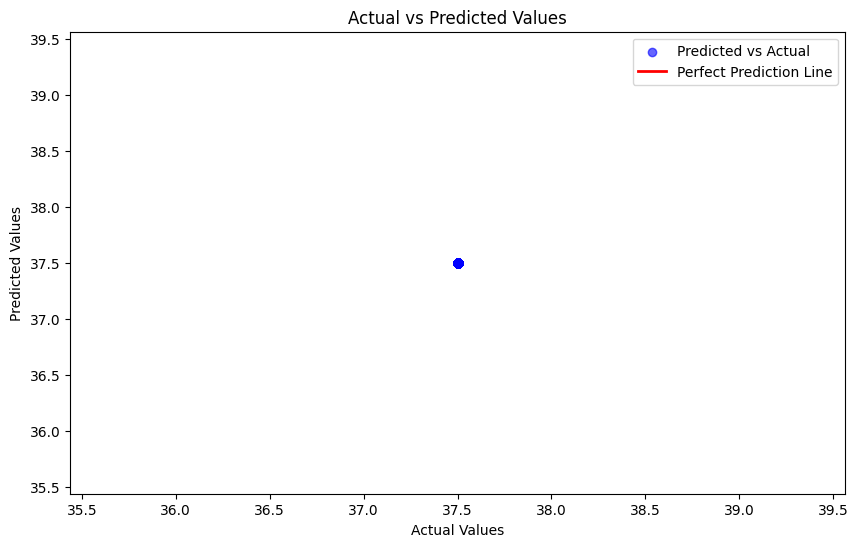

In [165]:
model_1, metrics_1 = train_demand_model_flexible(df_combined_processed)

### Training model with IOT data
Evaluation of model training with IOT data shows that model performs better when IOT data is not involved. This suggests that this model may perhaps be too simple to handle the IOT data, either that or that the synthetically-generated IOT data does not replicate the correlation between the features to the predicted demand enough to be helpful for the model. 

In [154]:
model_2, metrics_2 = train_demand_model_flexible(df_all_combined_processed)

📡 Detected IoT features. Using full feature set.
🧮 Features used: ['Favorite_Attraction', 'Avg_Wait_Time', 'Satisfaction_Score', 'Age_Group', 'Employment_Status', 'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature', 'relative_humidity', 'wind_speed', 'Visitor_ID', 'Loyalty_Member', 'Age', 'Gender', 'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending', 'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction', 'Year', 'Month']
🎯 Target: Avg_Wait_Time


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 628, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1137, in _create_dmatrix
    return QuantileDMatrix(
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 1614, in __init__
    self._init(
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 1678, in _init
    it.reraise()
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 572, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 553, in _handle_exception
    return fn()
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 640, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py", line 1654, in next
    input_data(**self.kwargs)
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 628, in input_data
    dispatch_proxy_set_data(self.proxy, new, cat_codes)
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py", line 1749, in dispatch_proxy_set_data
    proxy._ref_data_from_columnar(data)  # pylint: disable=W0212
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 1466, in _ref_data_from_columnar
    _check_call(
  File "c:\Users\parma\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [17:05:44] C:\actions-runner\_work\xgboost\xgboost\src\data\array_interface.h:218: Check failed: m == 1 || n == 1: 


## Modelling with Random Forest

In [111]:
def train_rf_demand_model_flexible(df, target='Number_of_People_in_Queue', fallback_target='Wait_Time'):
    """
    Trains a Random Forest Regressor for demand prediction.
    Automatically detects if IoT features are present and adjusts features accordingly.

    Args:
        df (pd.DataFrame): Merged dataset (survey + weather [+ iot])
        target (str): Main prediction target (default: 'Number_of_People_in_Queue')
        fallback_target (str): Backup target if main target is missing (default: 'Wait_Time')

    Returns:
        model (RandomForestRegressor): Trained model
        metrics (dict): R², RMSE, MAE
    """
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    from sklearn.preprocessing import LabelEncoder
    from pandas.api.types import is_object_dtype

    # --- Determine which target to use ---
    if target in df.columns and df[target].notna().any():
        actual_target = target
    elif fallback_target in df.columns and df[fallback_target].notna().any():
        actual_target = fallback_target
        print(f"⚠️ '{target}' not found. Using fallback target '{fallback_target}'.")
    else:
        raise ValueError("❌ No valid target found in dataset.")

    # --- Define feature sets ---
    full_features = [
        'Season', 'Attraction', 'Wait_Time', 'Guest_Satisfaction_Score',
        'rainfall', 'relative_humidity', 'air_temperature',
        'Average_Queue_Time', 'Check_In_Time', 'Check_Out_Time'
    ]
    fallback_features = [
        'Season', 'Attraction', 'Event', 'Guest_Satisfaction_Score',
        'rainfall', 'air_temperature', 'relative_humidity', 'wind_speed'
    ]

    if all(col in df.columns for col in full_features):
        used_features = full_features
        print("📡 IoT features detected. Using full feature set.")
    else:
        used_features = [col for col in fallback_features if col in df.columns]
        print("📋 Using reduced survey feature set.")

    print(f"🧮 Features used: {used_features}")
    print(f"🎯 Target: {actual_target}")

    # --- Drop rows with missing target ---
    df = df[df[actual_target].notna()]
    if df.empty:
        raise ValueError("❌ No rows with valid target values.")

    df = df[used_features + [actual_target]].copy()

    # --- Fill missing values ---
    for col in used_features:
        if col not in df.columns:
            continue
        if is_object_dtype(df[col]):
            df[col] = df[col].fillna("Unknown")
        else:
            df[col] = df[col].fillna(df[col].mean())

    # --- Encode categorical features ---
    for col in ['Season', 'Attraction', 'Event']:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # --- Train-test split ---
    X = df[used_features]
    y = df[actual_target]

    if len(df) < 5:
        raise ValueError("❌ Not enough data to train.")

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Train Random Forest ---
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- Evaluation ---
    metrics = {
        'R² Score': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

    print("✅ Random Forest model trained successfully.")
    print("📊 Evaluation:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return model, metrics


### Modelling with no IOT dataset

Yields better results than XGBoost in terms of R^2 square, albeit still low. 

In [112]:
model_gb_1, metrics_gb_1 = train_rf_demand_model_flexible(df_combined)

ValueError: ❌ No valid target found in dataset.

### Modelling with IOT dataset
Results are around the same, indicating that instead of modelling issue, it's perhaps more of a data distribution issue that lacks accuracy in resembling real-life distribution. 

In [ ]:
model_gb_2, metrics_gb_2 = train_rf_demand_model_flexible(df_all_combined)

📡 IoT features detected. Using full feature set.
🧮 Features used: ['Season', 'Attraction', 'Wait_Time', 'Guest_Satisfaction_Score', 'rainfall', 'relative_humidity', 'air_temperature', 'Average_Queue_Time', 'Check_In_Time', 'Check_Out_Time']
🎯 Target: Number_of_People_in_Queue
✅ Random Forest model trained successfully.
📊 Evaluation:
R² Score: 0.0173
RMSE: 86.0086
MAE: 74.6279


# Simulating some of the demand for attractions, restaurants, and merchandise shops
This function simulates daily visitor demand across different attractions and services at USS by predicting the number of people in queue based on future conditions (e.g., weather, season, ride popularity, etc.).

📤 Output:
Prints demand predictions in 3 segments:
🎢 Predicted Queue Size by Attraction: 
- Average number of people expected in queue per attraction per day.
Note: This represents the average instantaneous queue length at a given point in the day.

🍔 Estimated Restaurant Demand by Season:
- Uses average predicted queue size per attraction in a season as a proxy for restaurant demand.
Assumes restaurant traffic correlates with attraction traffic.

🎁 Estimated Merchandise Demand:
- Estimates the number of people likely to exit after 5PM (e.g., visiting shops near the exit).
- Based on the predicted queue sizes of attractions for people with Check_Out_Time >= 17.


In [ ]:
def simulate_demand_predictions(model, features_df, label_encoders=None):
    """
    Generates and prints demand predictions using the trained model for attractions and services.

    Args:
        model: Trained XGBoost model.
        features_df (pd.DataFrame): Input features for prediction (should match training format).
        label_encoders (dict): Optional, if Season or Attraction were label-encoded.
    """

    df = features_df.copy()

    # Encode Season and Attraction if needed
    if label_encoders:
        for col in ['Season', 'Attraction']:
            if col in df.columns and col in label_encoders:
                df[col] = label_encoders[col].transform(df[col].astype(str))

    predictions = model.predict(df)
    features_df['Predicted_Queue'] = predictions

    # --- Summarize demand per attraction ---
    print("\n🎢 Predicted Queue Size by Attraction (avg. people in queue today):")
    print(features_df.groupby("Attraction")['Predicted_Queue'].mean().round(1).sort_values(ascending=False))

    # --- Estimate restaurant demand per season (proxy: mean attraction demand) ---
    print("\n🍔 Estimated Restaurant Demand by Season (avg. people per attraction per day):")
    restaurant_demand = features_df.groupby("Season")['Predicted_Queue'].mean().round(1)
    print(restaurant_demand)

    # --- Estimate merchandise demand (clustered at exit) ---
    print("\n🎁 Estimated Merchandise Demand (avg. people exiting after 5PM per day):")
    exit_demand = features_df[features_df['Check_Out_Time'] >= 17]  # Assume late checkout = near exit
    merch_demand = exit_demand['Predicted_Queue'].mean().round(1) if not exit_demand.empty else 0
    print(f"Expected merchandise shop crowding (near exit): {merch_demand} people (avg)")


Example of simulation with synthetic data.

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Sample input for next 3 days
df_future = pd.DataFrame({
    'Season': ['July - September'] * 5,
    'Attraction': [
        "Revenge of the Mummy",
        "Transformers: The Ride",
        "Puss In Boots' Giant Journey",
        "Sesame Street Spaghetti Space Chase",
        "Battlestar Galactica: CYLON"
    ],
    'Wait_Time': [35, 45, 30, 25, 40],
    'Guest_Satisfaction_Score': [0.7, 0.8, 0.6, 0.9, 0.75],
    'rainfall': [1.2] * 5,
    'relative_humidity': [82] * 5,
    'air_temperature': [30] * 5,
    'Average_Queue_Time': [45, 50, 40, 30, 55],
    'Check_In_Time': [10, 11, 9, 10, 12],
    'Check_Out_Time': [18, 17, 16, 19, 18]
})

# Encode categorical fields if needed
label_encoders = {}
for col in ['Season', 'Attraction']:
    le = LabelEncoder()
    le.fit(df_all_combined[col].astype(str))  # Fit on the full dataset
    label_encoders[col] = le

simulate_demand_predictions(model_2, df_future, label_encoders)



🎢 Predicted Queue Size by Attraction (avg. people in queue today):
Attraction
Sesame Street Spaghetti Space Chase    172.800003
Transformers: The Ride                 124.099998
Battlestar Galactica: CYLON            120.400002
Revenge of the Mummy                   102.900002
Puss In Boots' Giant Journey            96.599998
Name: Predicted_Queue, dtype: float32

🍔 Estimated Restaurant Demand by Season (avg. people per attraction per day):
Season
July - September    123.400002
Name: Predicted_Queue, dtype: float32

🎁 Estimated Merchandise Demand (avg. people exiting after 5PM per day):
Expected merchandise shop crowding (near exit): 130.10000610351562 people (avg)
